In [1]:
import transitleastsquares as tls
import lightkurve as lk
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from astropy.time import Time

In [2]:
%config InlineBackend.figure_format="retina" 

In [3]:
sns.set(context="talk", style="white")

## Download data

In [4]:
tpfs = lk.search_targetpixelfile("WASP-50", author="TESS-SPOC").download_all()

In [28]:
r = SIP(tpfs)

/home/mango/miniconda3/envs/gen/lib/python3.9/site-packages/lightkurve/lightcurve.py:1031: LightkurveWarning: The light curve appears to be zero-centered (median=1.94e+04 electron / s +/- 6.63e+04 electron / s); `normalize()` will divide the light curve by a value close to zero, which is probably not what you want.
  warnings.warn(


ValueError: array must not contain infs or NaNs

In [23]:
r.keys()

dict_keys(['periods', 'power', 'raw_lc', 'power_bkg', 'raw_lc_bkg', 'corr_lc', 'period_at_max_power'])

In [4]:
srs = lk.search_lightcurve("WASP-50", author="SPOC", exptime=120)
srs

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 04,2018,SPOC,120,382391899,0.0
1,TESS Sector 31,2020,SPOC,120,382391899,0.0


In [5]:
lcs = srs.download_all()
lcs

LightCurveCollection of 2 objects:
    0: <TessLightCurve LABEL="TIC 382391899" SECTOR=4 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    1: <TessLightCurve LABEL="TIC 382391899" SECTOR=31 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>

In [32]:
lcs[1].meta

{'INHERIT': True,
 'EXTNAME': 'PRIMARY',
 'EXTVER': 1,
 'SIMDATA': False,
 'TELESCOP': 'TESS',
 'INSTRUME': 'TESS Photometer',
 'OBJECT': 'TIC 382391899',
 'TICID': 382391899,
 'RADESYS': 'ICRS',
 'RA_OBJ': 43.6880594592075,
 'DEC_OBJ': -10.8980627883611,
 'EQUINOX': 2000.0,
 'EXPOSURE': 20.140839702886,
 'TIMEREF': 'SOLARSYSTEM',
 'TASSIGN': 'SPACECRAFT',
 'TIMESYS': 'TDB',
 'BJDREFI': 2457000,
 'BJDREFF': 0.0,
 'TIMEUNIT': 'd',
 'TELAPSE': 25.43035316021,
 'LIVETIME': 20.14083970288629,
 'TSTART': 2144.519206073544,
 'TSTOP': 2169.949559002273,
 'DATE-OBS': '2020-10-22T00:26:30.221',
 'DATE-END': '2020-11-16T10:46:12.714',
 'DEADC': 0.792,
 'TIMEPIXR': 0.5,
 'TIERRELA': 1.16e-05,
 'INT_TIME': 1.98,
 'READTIME': 0.02,
 'FRAMETIM': 2.0,
 'NUM_FRM': 60,
 'TIMEDEL': 0.001388888888888889,
 'BACKAPP': True,
 'DEADAPP': True,
 'VIGNAPP': True,
 'GAINA': 5.21999979019165,
 'GAINB': 5.210000038146973,
 'GAINC': 5.210000038146973,
 'GAIND': 5.260000228881836,
 'READNOIA': 10.022398948669434,
 

We have two TESS datasets to work with

Note: BTJD = BJD - 2457000.0

## SAP

Text(0.5, 1.0, '')

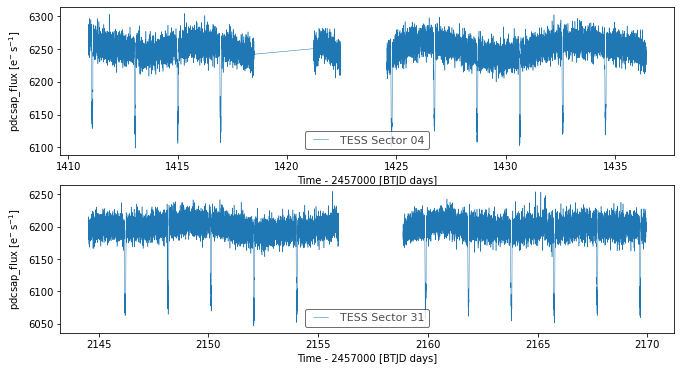

In [6]:
fig, axes = plt.subplots(2, 1, figsize=(11, 6))

for (ax, lc, sr) in zip(axes.flat, lcs, srs):
    lc.plot(ax=ax, column='pdcsap_flux', label=sr.mission[0])
    
ax.set_title("")

## PDCSAP

In [3]:
fig, axes = plt.subplots(2, 1, figsize=(11, 6))

for (ax, lc, sr) in zip(axes.flat, lcs, srs):
    lc.plot(ax=ax, label=sr.mission[0])

NameError: name 'plt' is not defined

Explicitly normalize and remove nans:

In [96]:
lc_sector_04 = lcs[0].normalize().remove_nans()
lc_sector_31 = lcs[1].normalize().remove_nans()

In [97]:
P = 1.9550931258
dur = 1.83 * (1.0 / 24.0)
t_0 = 2455558.61237

In [98]:
def compute_baseline(lc, P, dur, t_0):
    in_transit = tls.transit_mask(lc.time.jd, P, dur, t_0)
    lc_baseline = lc[~in_transit]
    return lc_baseline

In [99]:
lc_sector_04_baseline = compute_baseline(lc_sector_04, P, dur, t_0)
lc_sector_31_baseline = compute_baseline(lc_sector_31, P, dur, t_0)

## Baseline flux

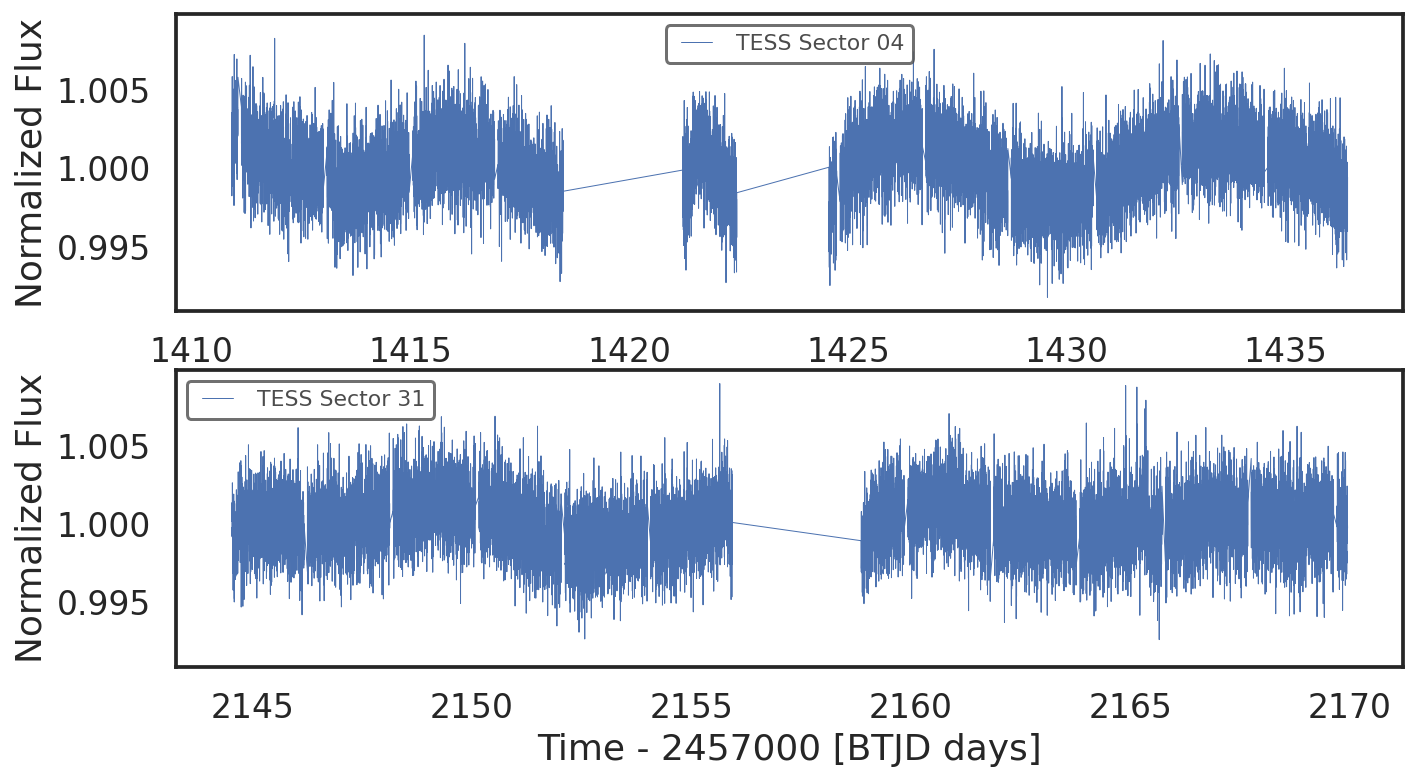

In [100]:
fig, axes = plt.subplots(2, 1, figsize=(11, 6), sharey=True)

lcs_baselines = [lc_sector_04_baseline, lc_sector_31_baseline]

for (ax, lc, sr) in zip(axes.flat, lcs_baselines, srs):
    lc.plot(ax=ax, label=sr.mission[0])

In [101]:
lcs_baselines[0].to_csv("../data/photometric/TESS_baseline_sector_04.csv", overwrite=True)
lcs_baselines[1].to_csv("../data/photometric/TESS_baseline_sector_31.csv", overwrite=True)

## Binned baseline flux

In [81]:
def weighted_avg_and_std(values, weights):
    """ Return the weighted average and standard deviation. values, weights -- Numpy ndarrays with the same shape."""
    average = np.average(values, weights=weights) #weights = 1./err_bar^2. Where err_bar=std & err_bar^2 = variance
    variance = np.average((values-average)**2, weights=weights) # Fast and numerically precise
    return average, np.sqrt(variance)

def BinDat(time, LC, LC_err, Bin=100):
    """Method to bin the data, using the weighted mean of a given databin size 'Bin.' The error is estimated using the
    technique discussed here https://stackoverflow.com/questions/2413522/weighted-standard-deviation-in-numpy"""
    Remainder = len(LC)%Bin
    LenSplit = int(np.trunc(len(LC)/Bin))
    if Remainder > 0: #To collect remainders for the last bin
        Main, mainErr, mainT= LC[:len(LC)-Remainder], LC_err[:len(LC_err)-Remainder], time[:len(time)-Remainder]
        Remain, RemainErr, remainT= LC[len(LC)-Remainder:], LC_err[len(LC_err)-Remainder:], time[len(time)-Remainder:]
        size = LenSplit+1
    else:
        Main, mainErr, mainT = LC, LC_err, time
        size = LenSplit
    BinLC, BinLCerr, BinT = np.zeros(size), np.zeros(size), np.zeros(size)
    Splits, splitErr, splitT = np.split(Main, LenSplit), np.split(mainErr, LenSplit), np.split(mainT, LenSplit)
    if Remainder: 
        Splits.append(Remain), splitErr.append(RemainErr), splitT.append(remainT)
    for S in range(len(Splits)):
        Avg, Err = weighted_avg_and_std(Splits[S], 1/(splitErr[S]**2)) #weight = 1/variance = 1/sig^2 = 1/err_bar^2
        BinLC[S], BinLCerr[S], BinT[S] = Avg, Err, np.mean(splitT[S])
    return BinLC, BinLCerr, BinT

In [88]:
np.all(lcs_baselines[0].flux == lcs_baselines[0].pdcsap_flux)

True

In [105]:
lcs_baselines[0].time

<Time object: scale='tdb' format='btjd' value=[1410.90769721 1410.90908613 1410.91047504 ... 1436.41316967 1436.41455853
 1436.41594738]>

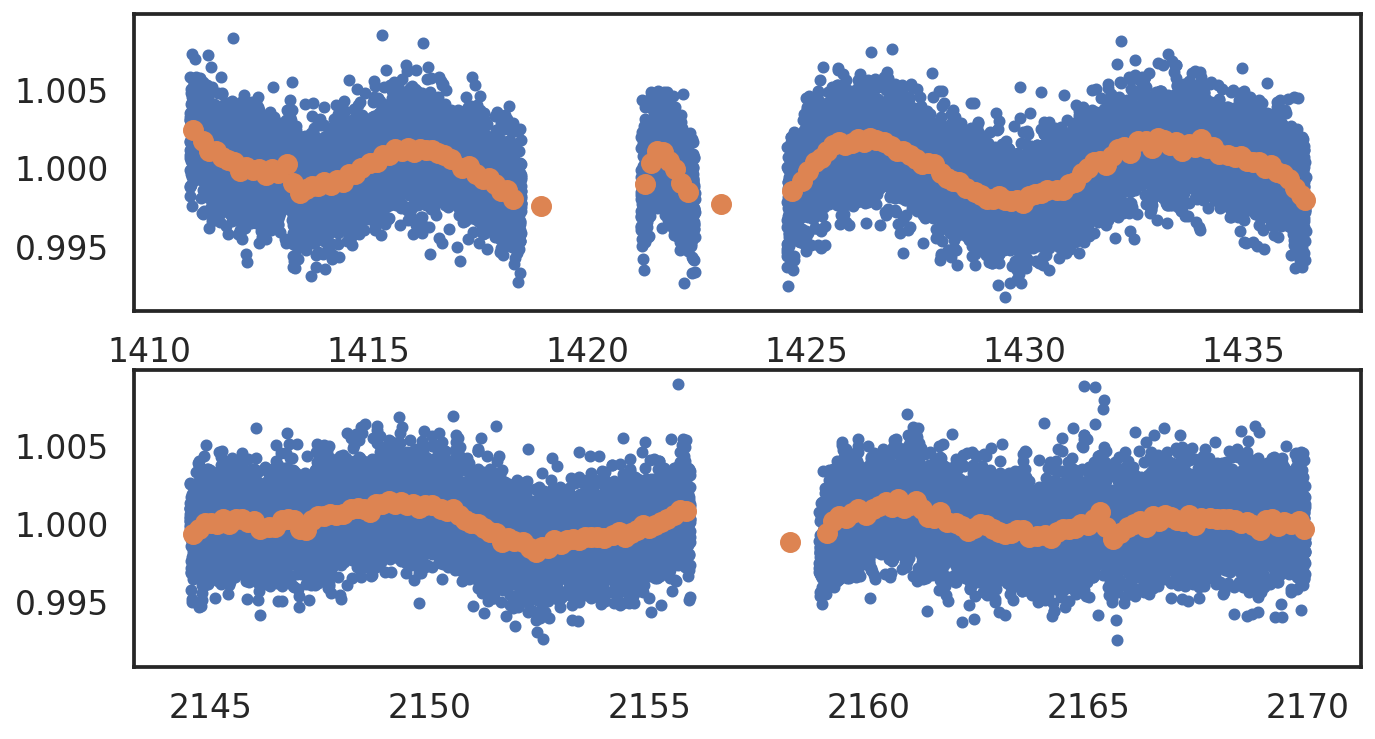

In [102]:
fig, axes = plt.subplots(2, 1, figsize=(11, 6), sharey=True)

for (ax, lc) in zip(axes.flat, lcs_baselines):
    binned_lc, binned_lc_err, binned_lc_time = BinDat(
        lc.time.btjd, lc.flux.value, lc.flux_err, Bin=100
    )
    ax.scatter(lc.time.btjd, lc.flux, marker='.')
    ax.scatter(binned_lc_time, binned_lc)